In [40]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import sklearn.datasets
from sklearn.decomposition import PCA, TruncatedSVD
import seaborn as sns

### Nacitaj tvare

In [29]:
_, _, files = list(os.walk("photos64"))[0]

faces = dict()

for f in files:
    f.encode('unicode_escape')
    img = cv2.imread("photos64/"+f)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces[f] = gray


### Nacitanie trenovacieho dataset

In [14]:
images = sklearn.datasets.fetch_olivetti_faces()["images"]

In [15]:
images.shape

(400, 64, 64)

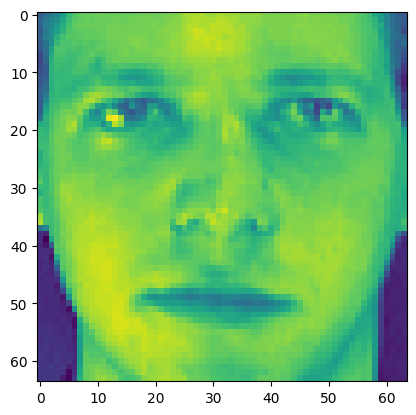

In [16]:
plt.imshow(images[0])

### Priemerna tvar

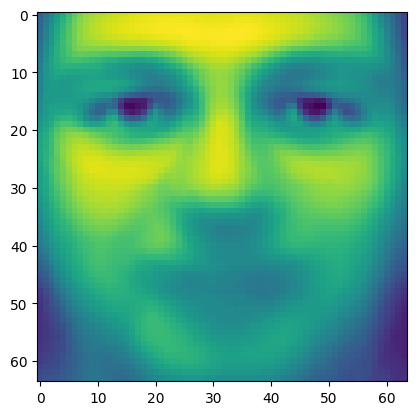

In [19]:
avg_face = np.zeros(64*64)    
for face in images:
    face_vec = face.flatten()
    #face_vec = face_vec.reshape(face_vec.shape[0], 1)
    avg_face += face_vec

avg_face = avg_face/len(images)
avg_face_img = avg_face.reshape(64, 64)
plt.imshow(avg_face_img)

### Rozdielny trenovacich oproti priemernej tvary

In [21]:
face_train_diffs = list()
for face in images:
    face_vec = face.flatten()
    face_train_diffs.append(face_vec - avg_face)

### Vypocitaj eigenfaces

In [25]:
A = np.matrix([i for i in face_train_diffs]).T
AtA = np.matmul(A.T, A)
_, vec = np.linalg.eigh(AtA)
eigen = np.array([np.array(np.matmul(A, v.T).T)[0] for v in vec]).T

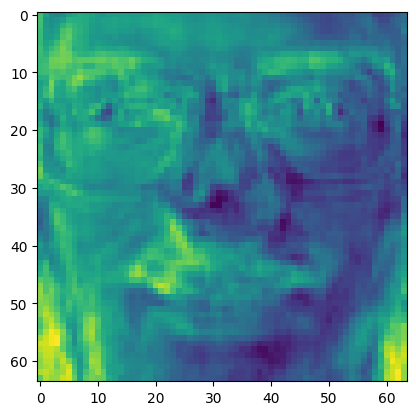

In [26]:
plt.imshow(eigen.T[1].reshape(64, 64))

### Rozdielny nasich oproti priemernej tvary

In [31]:
face_diffs = dict()
for name, face in faces.items():
    face_vec = face.flatten()
    face_diffs[name] = face_vec - avg_face

### Vypocitaj koeficienty eigenfaces pre jednotlive tvare

In [32]:
%%time
face_vals = dict()
for name, face in face_diffs.items():
    face_vals[name] = np.linalg.lstsq(eigen, face, rcond=None)[0]

CPU times: total: 35.8 s
Wall time: 2min 21s


In [33]:
names = []
vals = []
for name, face in face_vals.items():
    names.append(name)
    vals.append(face)

### Hľadanie lakťa na celych dátach

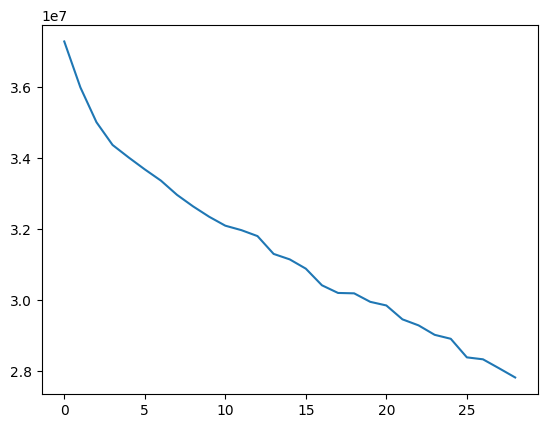

In [74]:
iner = []
for i in range(1,30):
    kmeans = KMeans(n_clusters=i, random_state=3, algorithm="lloyd").fit(vals)
    iner.append(kmeans.inertia_)

plt.plot(iner)

In [37]:
for name1, val1 in face_vals.items():
    best_dist = float("inf")
    best_name = ""
    for name2, val2 in face_vals.items(): 
        if name1 != name2 and np.linalg.norm(val1 - val2) < best_dist:
            best_dist = np.linalg.norm(val1 - val2)
            best_name = name2
    #print("Najpodobnejsia tvar k", name1, "je", best_name, best_dist)
    print(f"{name1:42} {best_name:42} {best_dist:1.18}")
            
        

AIN extra_Alexander Simko_align.jpg        AIN_Igor Farkas_align.jpg                  320.218264907241178
AIN extra_Andrej Lucny_align.jpg           KJFB_Stanislav Tokar DrSc_align.jpg        455.998819917455705
AIN extra_Barbora Cimrova_align.jpg        AIN_Jozef Siska_align.jpg                  340.625427770876968
AIN extra_Damas Gruska_align.jpg           KTF_Eduard Masar CSc_align.jpg             434.722997549349259
AIN extra_Dusan Guller_align.jpg           KEF_Zuzana Zabudla_align.jpg               298.946269663190378
AIN extra_Frantisek Gyarfas_align.jpg      KEF_Zuzana Zabudla_align.jpg               291.980374041761479
AIN extra_Jan Komara_align.jpg             AIN extra_Pavel Petrovic_align.jpg         472.411792997701355
AIN extra_Lubica Benuskova_align.jpg       AIN_Maria Lucka_align.jpg                  482.438713461957377
AIN extra_Maria Markosova_align.jpg        KAFZM_Peter Jevcak_align.jpg               506.22997263676001
AIN extra_Martin Takac_align.jpg           AIN 

### Zmensenie dimenzie pomocou Principal Component Analysis

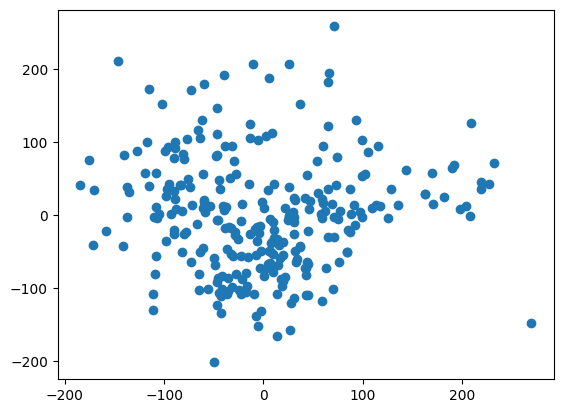

In [88]:
pca = PCA(n_components=2).fit_transform(vals)
plt.scatter(x=pca[:, 0], y=pca[:, 1])

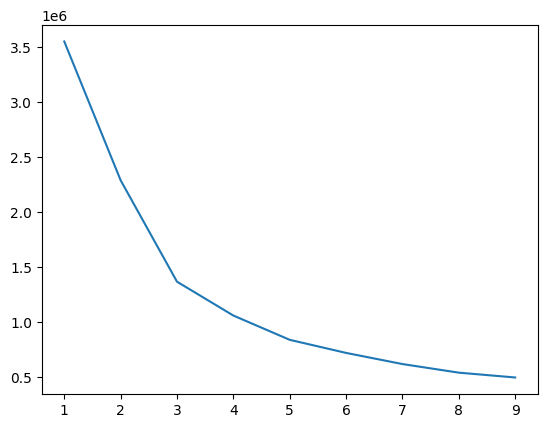

In [96]:
iner = []
rang = list(range(1,10))
for i in rang:
    kmeans = KMeans(n_clusters=i, random_state=0, algorithm="lloyd").fit(pca)
    iner.append(kmeans.inertia_)

plt.plot(rang, iner)

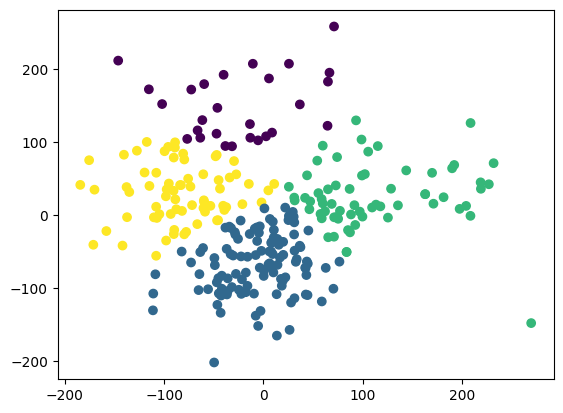

In [85]:
kmeans = KMeans(n_clusters=4, random_state=0, algorithm="lloyd").fit(pca)
plt.scatter(x=pca[:, 0], y=pca[:, 1], c=kmeans.labels_)


### Zmensenie dimenzie pomocou Singular Value Decomposition

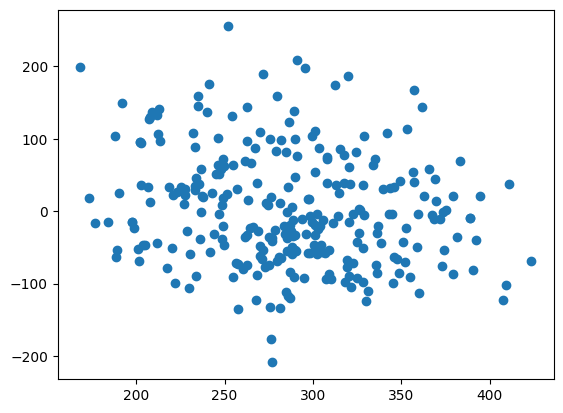

In [87]:
svd = TruncatedSVD(n_components=2).fit_transform(vals)
plt.scatter(x=svd[:, 0], y=svd[:, 1])

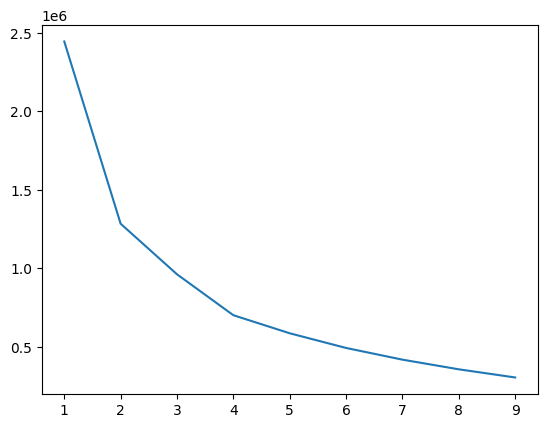

In [97]:
iner = []
rang = list(range(1,10))
for i in rang:
    kmeans = KMeans(n_clusters=i, random_state=3, algorithm="lloyd").fit(svd)
    iner.append(kmeans.inertia_)

plt.plot(rang, iner)

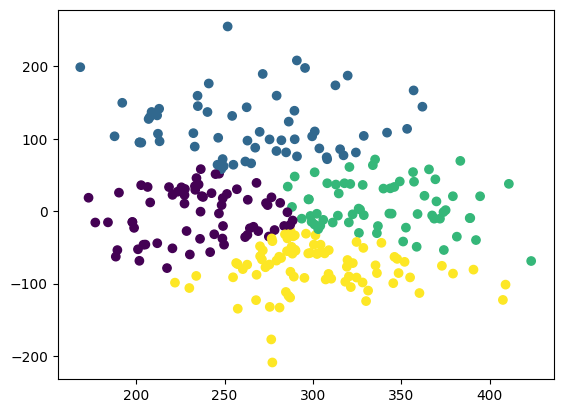

In [93]:
kmeans = KMeans(n_clusters=4, random_state=0, algorithm="lloyd").fit(svd)
plt.scatter(x=svd[:, 0], y=svd[:, 1], c=kmeans.labels_)